# Previous notebooks:
    Create TFrecord:[link](https://www.kaggle.com/carloszonetgmailcom/create-tfrecord)
    Model training:[![link]](https://www.kaggle.com/carloszonetgmailcom/asthma-trigger-prediction-model-trainning)
    Prediction: https://www.kaggle.com/carloszonetgmailcom/astham-trigger-prediction-prediction

In [1]:
!pip install -q efficientnet
import os
import numpy as np 
import pandas as pd
import random
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread as imread
from skimage.util import montage
from skimage.color import label2rgb
import cv2
from sklearn.model_selection import train_test_split
import tensorflow.keras.applications as tfka
import efficientnet.tfkeras as efn

In [2]:
# dataset path
img_path = '../input/food-ingredients-and-recipe-dataset-with-images/Food Images/Food Images/'

# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32

# seed
seed = 9527

# image size
IMAGE_SIZE = [256, 256]

# Label_dim
label_dim = 1

# common_allergens list
common_allergens = {
    'cows milk': {'Cheese', 'Butter', 'Margarine', 'Yogurt', 'Cream', 'Ice cream'},
    'eggs': {'egg'},
    'tree nuts': {'Brazil nut', 'Almond', 'Cashew', 'Macadamia nut', 'Pistachio','Pine nut','Walnut'},
    'peanuts': {'peanut'},
    'shellfish': {'Shrimp','Prawn','Crayfish', 'Lobster', 'Squid', 'Scallops'},
    'wheat': {'flour', 'wheat', 'pasta', 'noodle', 'bread', 'crust'},
    'soy': {'soy', 'tofu', 'soya'},
    'fish': {'fish', 'seafood'}
}

# Targets list
targets = allergens = ["cows_milk", "eggs", "tree nuts", "peanuts", "shellfish", "wheat", "soy", "fish"]

RGB_FLIP = 1 # should rgb be flipped when rendering images

In [3]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

def image_mapping_check(dataset):
    counter = 0
    record = []
    while counter < dataset.shape[0]-1:
        row = dataset.loc[counter]
        img_name = row['Image_Name']
        img = cv2.imread(img_path+img_name+'.jpg')
        try:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) 
        except:
            record.append(counter)
        counter+= 1
    new = dataset.drop(record, axis = 0)
    new = new.reset_index(drop = True)
    return new

def allergens_mapping(row, types):
    for item in common_allergens[types]:
        if item.lower() in row.lower():
                return 1
    return 0

def combination(row):
    return(row['cows_milk'], row['eggs'], row['tree nuts'], row['peanuts'], row['shellfish'], row['wheat'], row['soy'], row['fish'])


def load_dataset():
    path = "../input/food-ingredients-and-recipe-dataset-with-images/Food Ingredients and Recipe Dataset with Image Name Mapping.csv"
    df = pd.read_csv(path)
    df = image_mapping_check(df)
    df['image_path'] = img_path + df['Image_Name'] + '.jpg'
    df['cows_milk'] = df['Cleaned_Ingredients'].apply(lambda x: allergens_mapping(x, types = 'cows milk'))
    df['eggs'] = df['Cleaned_Ingredients'].apply(lambda x: allergens_mapping(x, types = 'eggs'))
    df['tree nuts'] = df['Cleaned_Ingredients'].apply(lambda x: allergens_mapping(x, types = 'tree nuts'))
    df['peanuts'] = df['Cleaned_Ingredients'].apply(lambda x: allergens_mapping(x, types = 'peanuts'))
    df['shellfish'] = df['Cleaned_Ingredients'].apply(lambda x: allergens_mapping(x, types = 'shellfish'))
    df['wheat'] = df['Cleaned_Ingredients'].apply(lambda x: allergens_mapping(x, types = 'wheat'))
    df['soy'] = df['Cleaned_Ingredients'].apply(lambda x: allergens_mapping(x, types = 'soy'))
    df['fish'] = df['Cleaned_Ingredients'].apply(lambda x: allergens_mapping(x, types = 'fish'))
    df['total'] = df.apply(combination, axis = 1)
    x_train, x_val, y_train, y_val = train_test_split(df['image_path'], df.iloc[:,7:16], shuffle = True, random_state = seed, test_size = 0.25)
    train_df = pd.concat([x_train, y_train], axis = 1).reset_index(drop = True)
    val_df = pd.concat([x_val, y_val], axis = 1).reset_index(drop = True)
    train_df.head()
    return df, train_df, val_df

In [4]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels = 3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Function to read our test image and return image
def read_image(image):
    image = tf.io.read_file(image)
    image = decode_image(image)
    return image

# Function to get our dataset that read images
def get_dataset(image):
    dataset = tf.data.Dataset.from_tensor_slices(image)
    dataset = dataset.map(read_image, num_parallel_calls = AUTO)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

In [5]:
# function to get theprediction result
def get_pred(image_paths,targets):
    inp = tf.keras.layers.Input(shape = (*IMAGE_SIZE, 3))
    final_pred = {}
    for target in targets:
        if target == "cows_milk":
            x = tfka.Xception(weights = 'imagenet', include_top = False)(inp)
            mode = 'XCP'
        if target == "eggs":
            x = efn.EfficientNetB5(weights = 'imagenet', include_top = False)(inp)
            mode = 'eff5'
        if target == "wheat":
            x = efn.EfficientNetB7(weights = 'imagenet', include_top = False)(inp)
            mode = 'eff7'
        else:
            x = tfka.ResNet50(weights = 'imagenet', include_top = False)(inp)
            mode = 'RN50'
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        output = tf.keras.layers.Dense(label_dim, activation='sigmoid')(x)
        model = tf.keras.models.Model(inputs = [inp], outputs = [output])
        
        weight_path = '../input/asthma-allenger-prediction-model-weights/'f'Model_{mode}_{target}_9527.h5'
        model.load_weights(weight_path)   
        img = get_dataset(image_paths)
        pred = model.predict(img)
        final_pred[target] = pred.tolist()
    return pd.DataFrame(final_pred)


In [6]:
# function to visualize our result
def prediction_example(x_val):
    t_yp = get_pred(x_val, targets)
    for target in targets:
        t_yp[target] = t_yp[target].apply(lambda x: x[0])

    fig, (m_axs) = plt.subplots(5, 2, figsize = (10, 20))
    for i, (c_ax, d_ax) in enumerate(m_axs):
        c_ax.imshow(read_image(x_val[i]))
        c_ax.axis('off')
        d_ax.barh(np.arange(len(allergens))+0.1, np.array(t_yp.iloc[i,:]), alpha=0.5, label='Predicted')
        d_ax.barh(np.arange(len(allergens))-0.1, np.array(y_val.iloc[i,:]), alpha=0.5, label='Ground Truth')
        d_ax.set_yticks(range(len(allergens)))
        d_ax.set_yticklabels(allergens, rotation=0)
        d_ax.legend();

258441216/258434480 [==============================] - 3s 0us/step


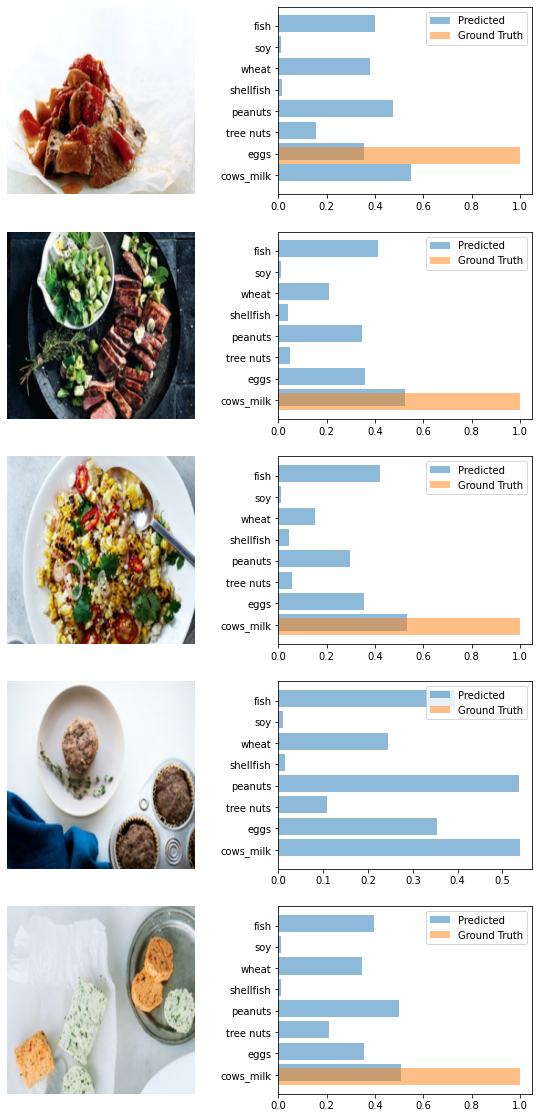

In [7]:
#
seed_everything(seed)

df, train_df, val_df = load_dataset()

x_val = val_df.image_path.values[5:10]
y_val = val_df.iloc[5:10,1:9]

prediction_example(x_val)